## ROC and Optimized Cut from dl2 files

This is an example of how to make ROC plots from a signal and background dl2 file, Then, a sensitivity-optimized cut is calculated on that dataset and compared to the ROC curves

In [1]:
import numpy as np
from dl2_tools.handler import sim_datasets,observation_handler
from dl2_tools.maker import roc_maker, RecoEnergyPointSourceGHCutOptimizer
import pkg_resources
import matplotlib.pyplot as plt
from pyirf.spectral import CRAB_HEGRA, IRFDOC_PROTON_SPECTRUM
import astropy.units as u
import os

/d1/hin/gschwefer/miniconda/envs/dl2_tools/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Get the directory where the data that comes with the package is stored

In [2]:
dl2_tools_dir = pkg_resources.resource_filename("dl2_tools","")
data_dir = os.path.join(dl2_tools_dir, 'data')


Load the individual files as DataSets. The point-like gammas are stored as a PointSourceSignalSet, the diffuse protons as a BackgroundSet 

In [3]:
signal=sim_datasets.PointSourceSignalSet.from_path(os.path.join(data_dir,"dl2_files/1-2run_gamma_20deg_0deg___cta-prod6-paranal-2147m-Paranal-nshow-100000-0-LSTs-14-MSTs-0-SSTs-NSCAT_5_CSCAT_1000-nsb-0.216-GHz_off0.0..FCExt--HillasReco--RF_red_100_est_dpth_20_01_lk_cut_int_wgt--IP_NC_dummy----RFCl_100_est_dpth_20_int_wgt.dl2.h5"),reco_energy_name="RF_red_100_est_dpth_20_01_lk_cut_int_wgt",geometry_name="HillasReconstructor",gh_score_name="RFCl_100_est_dpth_20_int_wgt")
background=sim_datasets.BackgroundSet.from_path(os.path.join(data_dir,"dl2_files/360-375run_proton_20deg_0deg___cta-prod6-paranal-2147m-Paranal-nshow-1200000-0-LSTs-14-MSTs-0-SSTs-NSCAT_5_CSCAT_1000_ESLOPE_2.7_off0.0..FCExt--HillasReco--RF_red_100_est_dpth_20_01_lk_cut_int_wgt--IP_NC_dummy----RFCl_100_est_dpth_20_int_wgt.dl2.h5"),reco_energy_name="RF_red_100_est_dpth_20_01_lk_cut_int_wgt",geometry_name="HillasReconstructor",gh_score_name="RFCl_100_est_dpth_20_int_wgt")

Both of these are then passed to a PointSourceObservationHandler object

In [4]:
observation=observation_handler.PointSourceObservationHandler(signal=[signal],background=[background])

For the ROC the weights are important. We here set them according to a flux from pyirf.spectral 

In [5]:
observation.signal.reweight_to(CRAB_HEGRA)
observation.background.reweight_to(IRFDOC_PROTON_SPECTRUM)

Next we set upt the ROCMaker, which makes the plots from the observation.

In [6]:
my_roc_maker=roc_maker.ROCMaker()
my_roc_maker.loss_vector=np.linspace(0.01,0.99,30) # Signal loss fractions to evaluate the curve at
my_roc_maker.radius_percentile=90 # The radius cut to set after g/h separation. This of course affects the purity
my_roc_maker.n_reco_energy_bins=2 # Number of bins in reconstructed energy to evaluate the gh and radius cut in
my_roc_maker.bkg_ring_size=5 # Maximum FoV offset of background to consider in background estimation

Run the roc_maker on the observation

In [7]:
my_roc_maker(observation)

Now make the plots. First, we can plot the background efficiency as a function of the fraction of signal cut away in all energy bins  (Only 2 in this case). The low satatistics of the dataset make it look so jiggly

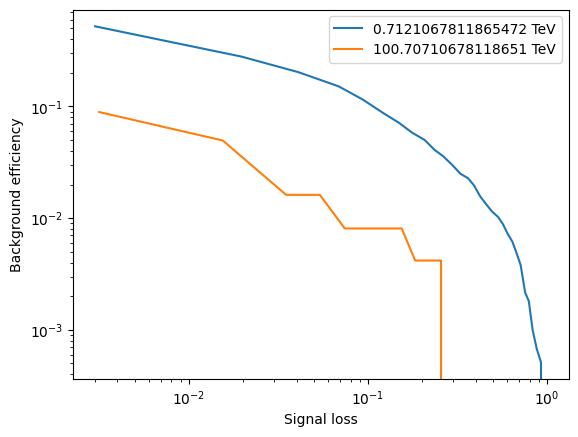

In [9]:
roc_fig, roc_ax = plt.subplots()
my_roc_maker.roc_plot_all_energy_bins(roc_ax,offset=0.0*u.deg)
roc_ax.legend()


We can also look at the ROC at any specified energy. Here we reproduce the above plot because there are only two energy bins

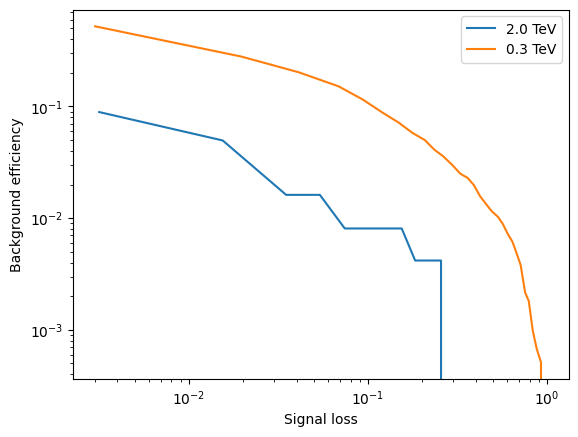

In [10]:
roc_fig_2, roc_ax_2 = plt.subplots()
my_roc_maker.roc_plot_single_energy(roc_ax_2,energy=2*u.TeV,offset=0.0*u.deg)
my_roc_maker.roc_plot_single_energy(roc_ax_2,energy=0.3*u.TeV,offset=0.0*u.deg)
roc_ax_2.legend()

Next, we can look at the background efficiency as a function of energy for a fixed signal efficiency.

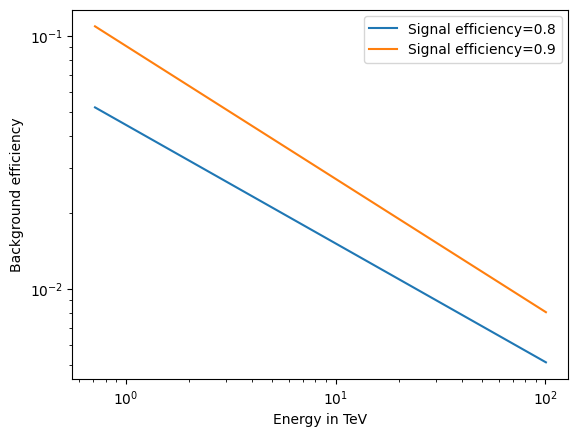

In [15]:
e_fig, e_ax = plt.subplots()
my_roc_maker.energy_plot_efficiencies(e_ax,efficiency=0.8,offset=0.0*u.deg)
my_roc_maker.energy_plot_efficiencies(e_ax,efficiency=0.9,offset=0.0*u.deg)
e_ax.legend()

Finally, we can calculate the area under the curve (auc) as a measure of the quality of the g/h separation. First in all energy bins...

In [16]:
my_roc_maker.integrate_auc_all_energy_bins(offset=0.0*u.deg)

/nfs/us0/gschwefer/code/projects/dl2_tools/src/dl2_tools/maker/roc_maker.py:401: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  auc = quad(f, 0, 1)


array([0.03930905, 0.0035226 ])

Then at a given energy

In [17]:
my_roc_maker.integrate_auc_single_energy(energy=0.1*u.TeV,offset=0.0*u.deg)

0.03930904548781648

Next, we calculate a sensitivity optimized g/h cut on the dataset using the RecoEnergyPointSOurceGHCutOptimizer module

In [18]:
gh_cut_optimizer=RecoEnergyPointSourceGHCutOptimizer()
gh_cut_optimizer.reco_energy_axis=my_roc_maker.reco_energy_axis
gh_cut_optimizer.gh_cut_efficiencies=np.linspace(0.5,0.95,46)
gh_cut_optimizer.alpha=0.02
gh_cut_optimizer.max_bkg_radius=5

In [19]:
gh_cut,_=gh_cut_optimizer(observation)

100%|██████████| 46/46 [00:01<00:00, 41.85it/s]


Then, using the calc_efficiencies_ps function of the ROCMaker, we can calcualte the signal loss and background efficiency of this cut in the same energy bins as above

In [20]:
opt_signal_loss,opt_bkg_rej=my_roc_maker.calc_efficiencies_ps(observation,gh_cut)

In [21]:
print(opt_signal_loss)
print(opt_bkg_rej)

[[0.55082937 0.45910873]]
[0.00950262 0.        ]


We can then plot this as afunction of energy together with the fixed efficiency cuts. This looks ugly here because the background efficeiency in the high energy bin is 0 in all cases, which of course does not work on the log scale of the plot

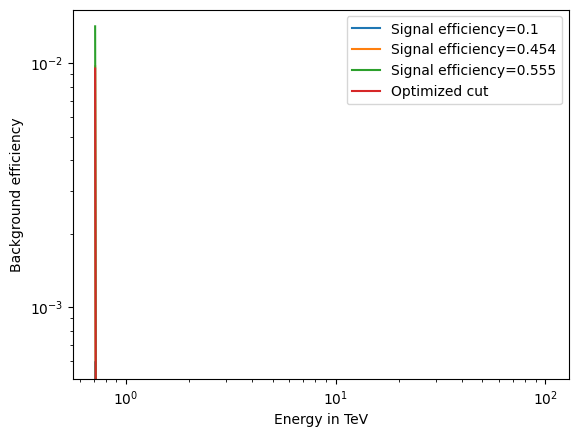

In [22]:
e_fig_2, e_ax_2 = plt.subplots()
my_roc_maker.energy_plot_efficiencies(e_ax_2,efficiency=0.1,offset=0.0*u.deg)
my_roc_maker.energy_plot_efficiencies(e_ax_2,efficiency=0.454,offset=0.0*u.deg)
my_roc_maker.energy_plot_efficiencies(e_ax_2,efficiency=0.555,offset=0.0*u.deg)
roc_maker.ROCMaker.make_energy_plot(e_ax_2,my_roc_maker.reco_energy_axis.center,opt_bkg_rej,label='Optimized cut')
e_ax_2.legend()